In [1]:
using Gen
using PyPlot

# Generate data

In [2]:
xs_dense = collect(range(-5, stop=5, length=50))
ys_simple = fill(1., length(xs_dense)) .+ randn(length(xs_dense)) * 0.1
ys_complex = [Int(floor(abs(x/3))) % 2 == 0 ? 2 : 0 for x in xs_dense] .+ randn(length(xs_dense)) * 0.1;

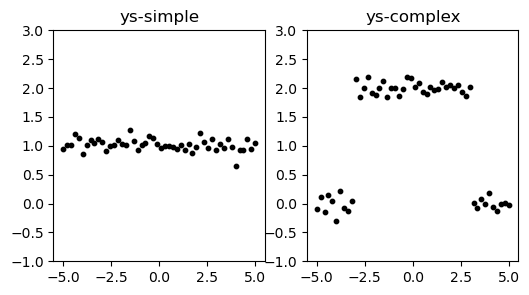

(-1.0, 3.0)

In [3]:
figure(figsize=(6,3))

subplot(1, 2, 1)
title("ys-simple")
scatter(xs_dense, ys_simple, color="black", s=10)
gca().set_ylim((-1, 3))

subplot(1, 2, 2)
title("ys-complex")
scatter(xs_dense, ys_complex, color="black", s=10)
gca().set_ylim((-1, 3))

# Define generative model

In [4]:
struct Interval
    l::Float64
    u::Float64
end

abstract type Node end
    
struct InternalNode <: Node
    left::Node
    right::Node
    interval::Interval
end

struct LeafNode <: Node
    value::Float64
    interval::Interval
end

In [8]:
@gen function generate_segments(l::Float64, u::Float64)
    interval = Interval(l, u)
    if @trace(bernoulli(0.7), :isleaf)
        value = @trace(normal(0, 1), :value)
        return LeafNode(value, interval)
    else
        frac = @trace(beta(2, 2), :frac)
        mid  = l + (u - l) * frac
        left = @trace(generate_segments(l, mid), :left)
        right = @trace(generate_segments(mid, u), :right)
        return InternalNode(left, right, interval)
    end
end

# get_value_at searches a binary tree for
# the leaf node containing some value.
function get_value_at(x::Float64, node::LeafNode)
    @assert x >= node.interval.l && x <= node.interval.u
    return node.value
end

function get_value_at(x::Float64, node::InternalNode)
    @assert x >= node.interval.l && x <= node.interval.u
    if x <= node.left.interval.u
        get_value_at(x, node.left)
    else
        get_value_at(x, node.right)
    end
end

# Our full model
@gen function changepoint_model(xs::Vector{Float64})
    node = @trace(generate_segments(minimum(xs), maximum(xs)), :tree)
    noise = @trace(gamma(1, 1), :noise)
    for (i, x) in enumerate(xs)
        @trace(normal(get_value_at(x, node), noise), (:y, i))
    end
    return node
end;

## Helper visualization functions

In [9]:
function grid(renderer::Function, traces; ncols=6, nrows=3)
    figure(figsize=(16, 8))
    for (i, trace) in enumerate(traces)
        subplot(nrows, ncols, i)
        renderer(trace)
    end
end;
function render_node(node::LeafNode)
    plot([node.interval.l, node.interval.u], [node.value, node.value])
end

function render_node(node::InternalNode)
    render_node(node.left)
    render_node(node.right)
end;
function render_segments_trace(trace)
    node = get_retval(trace)
    render_node(node)
    ax = gca()
    ax.set_xlim((0, 1))
    ax.set_ylim((-3, 3))
end;
function render_changepoint_model_trace(trace; show_data=true)
    xs = Gen.get_args(trace)[1]
    node = Gen.get_retval(trace)
    render_node(node)
    if show_data
        ys = [trace[(:y, i)] for i=1:length(xs)]
        scatter(xs, ys, c="black")
    end
    ax = gca()
    ax.set_xlim((minimum(xs), maximum(xs)))
    ax.set_ylim((-3, 3))
end;

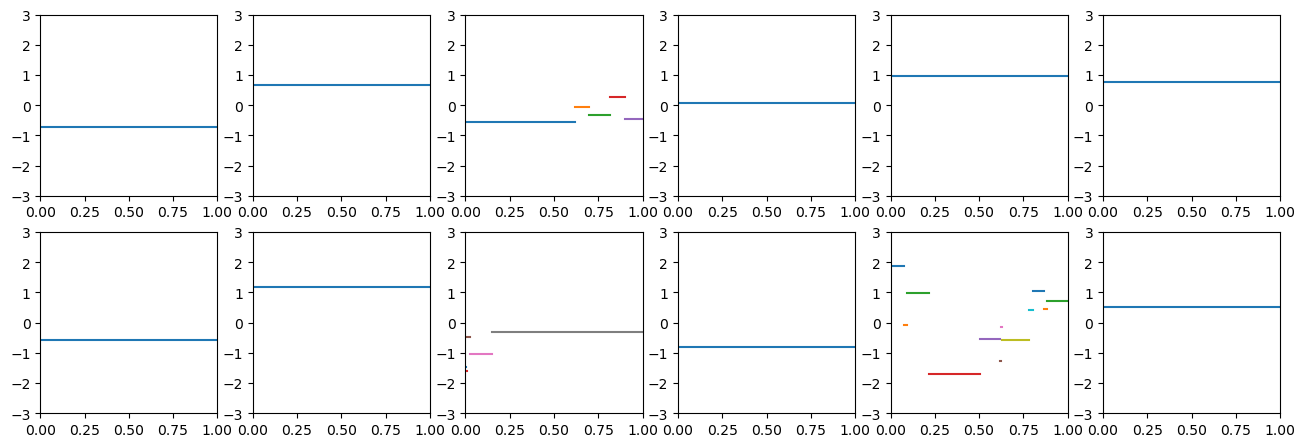

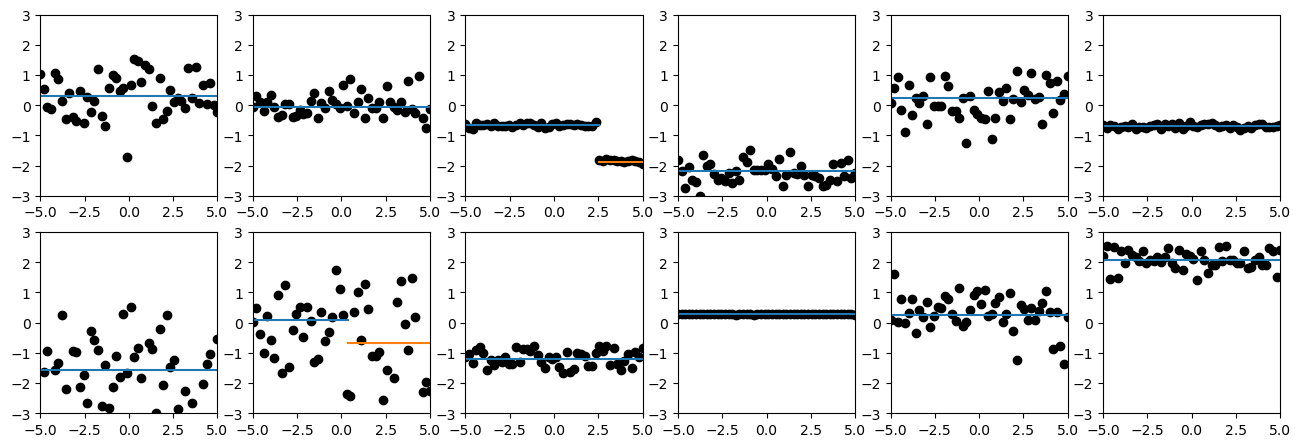

In [10]:
traces = [Gen.simulate(generate_segments, (0., 1.)) for i=1:12]
grid(render_segments_trace, traces)
traces = [Gen.simulate(changepoint_model, (xs_dense,)) for i=1:12]
grid(render_changepoint_model_trace, traces)

# Use importance sampling for inference

In [13]:
function do_inference_is(model, xs, ys, amount_of_computation)
    
    # Create a choice map that maps model addresses (:y, i)
    # to observed values ys[i]. We leave :slope and :intercept
    # unconstrained, because we want them to be inferred.
    observations = Gen.choicemap()
    for (i, y) in enumerate(ys)
        observations[(:y, i)] = y
    end
    
    # Call importance_resampling to obtain a likely trace consistent
    # with our observations.
    (trace, _) = Gen.importance_resampling(model, (xs,), observations, amount_of_computation);
    return trace
end;

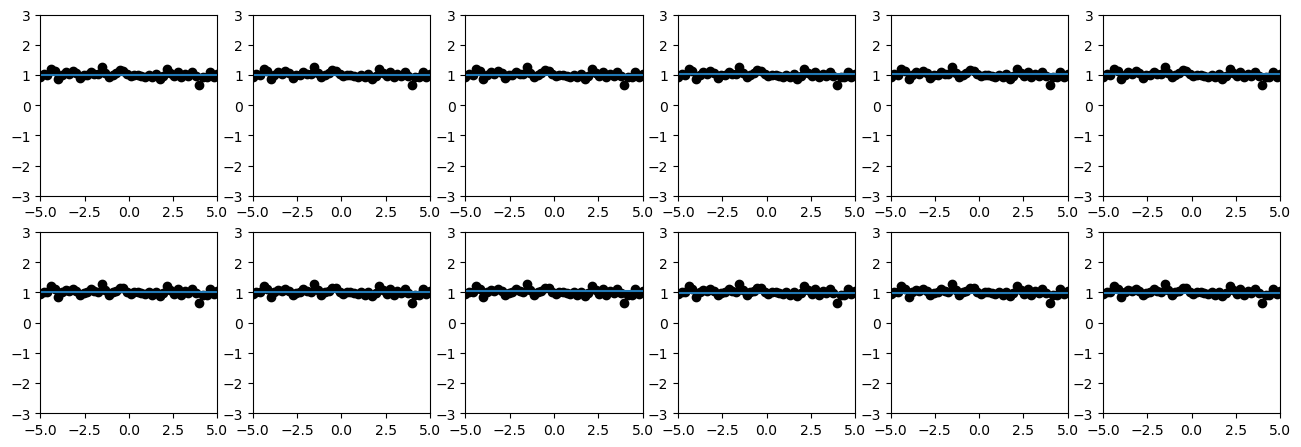

In [14]:
traces = [do_inference_is(changepoint_model, xs_dense, ys_simple, 10000) for _=1:12];
grid(render_changepoint_model_trace, traces)

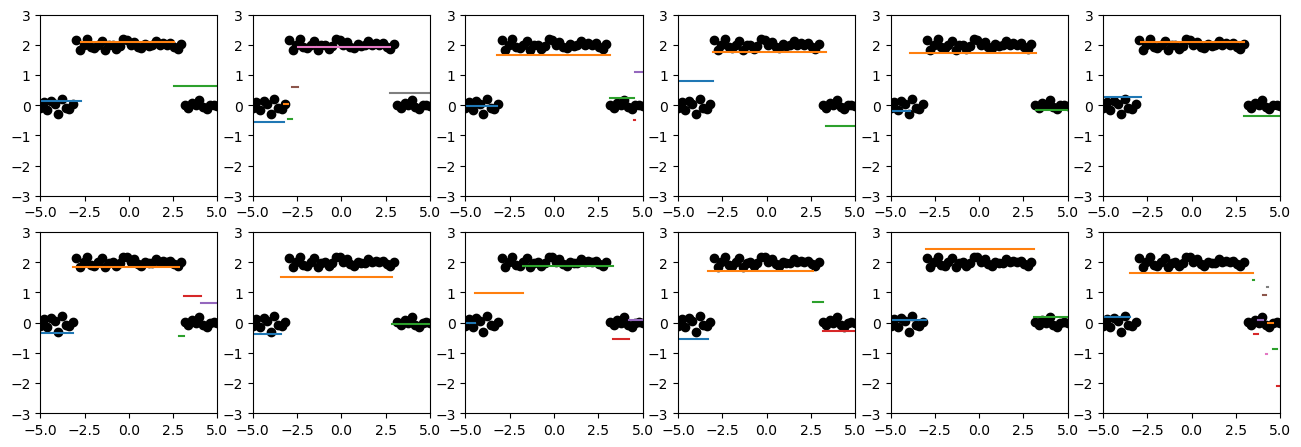

In [15]:
traces = [do_inference_is(changepoint_model, xs_dense, ys_complex, 100000) for _=1:12];
grid(render_changepoint_model_trace, traces)